In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Acquisition
##### Flat Acquisition using csv files

In [2]:
movies = pd.read_csv('./data/movies.csv')
# genome_scores = pd.read_csv('./data/genome-scores.csv')
# genome_tags = pd.read_csv('./data/genome-tags.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')

In [3]:
# print the first 5 rows of the movies, ratings, and tags dataframes
print(movies.head())
print(ratings.head())
print(tags.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
   userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732      

In [4]:
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Merge dei dataset movies e ratings
# rimuove i film che non hanno rating
movies_ratings = pd.merge(movies, grouped_ratings, on='movieId')
movies_ratings.head()

,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [5]:
# mantiene i duplicati, per rimuoverli usare .apply[set, list]
# tags.groupby('movieId')['tag'].apply(set)
new_tags = tags.groupby('movieId')['tag'].apply(set).apply(list)

df = pd.merge(movies_ratings, new_tags, on='movieId')
df.head()

,movieId,title,genres,mean_rating,rating_count,mean_timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,"[villian hurts toys, itaege, good cartoon chin..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,"[Robin Williams, bad cgi, itaege, new home, Ch..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,"[Burgess Meredith, old people that is actually..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,"[chick flick, divorce, single mother, CLV, cha..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,"[aging, pregnancy, Fantasy, Steve Martin, CLV,..."


## Data Visualization

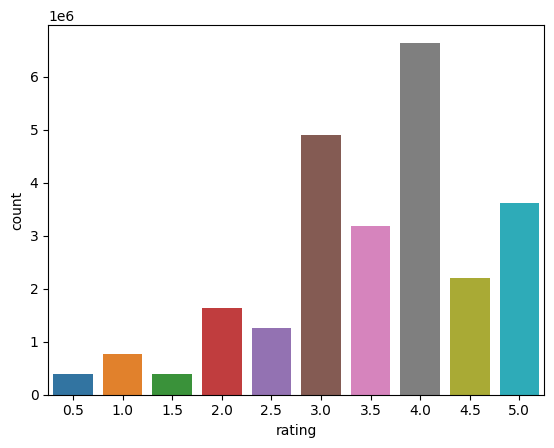

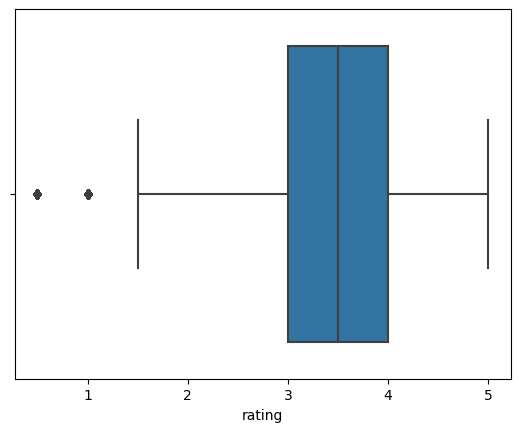

In [6]:
# Per capire la distribuzione dei rating
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show()

In [126]:
# Observing the distribution of all attributes for every file
# This is useful to show data trends, to reveal outliers and leverage points, to provide hints about modeling techniques to apply.

# print distribution for ratings
fig, axs = plt.subplots(3)
sns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')
sns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')
plt.show()

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

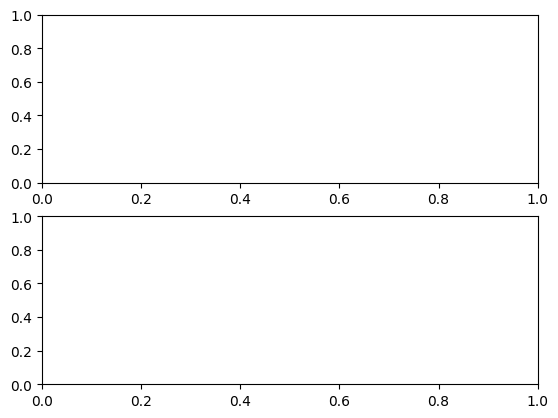

In [ ]:
# print distribution for movies
fig, axs = plt.subplots(2)
sns.kdeplot(movies['title'], ax=axs[1], color='b', label='title')
sns.kdeplot(movies['genres'], ax=axs[2], color='g', label='genres')
plt.show()


## Data Preprocessing

In [7]:
df_preprocessed = df.copy()

# from title extract year
df_preprocessed['year'] = df_preprocessed['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df_preprocessed['year'] = df_preprocessed['year'].str.extract('(\d{4})', expand=True)
#print(df_preprocessed.head())

# df with movies that have no year or year is not numeric \d{4}
year_not_numeric = df_preprocessed.loc[df_preprocessed['year'].isna()]
print(year_not_numeric)

# remove movies with no year
df_preprocessed = df_preprocessed.dropna(subset=['year'])

# delete title column
df_preprocessed = df_preprocessed.drop(columns=['title'])

df = df_preprocessed.copy()

       movieId                                    title  \
14311    79607  Millions Game, The (Das Millionenspiel)   
23377   125958       Stephen Fry In America - New World   
23488   126438           Two: The Story of Roman & Nyro   
23570   127005          A Year Along the Abandoned Road   
23926   128612                               Body/Cialo   
...        ...                                      ...   
41636   203922               Sherlock: The Blind Banker   
41678   204692                        In the Tall Grass   
41703   205074                         Falling Inn Love   
41788   206757                                    Twice   
41791   206781       The Black Legend of Mexican Cinema   

                             genres  mean_rating  rating_count  \
14311  Action|Drama|Sci-Fi|Thriller     3.400000            10   
23377            (no genres listed)     3.394737            19   
23488             Documentary|Drama     3.000000             1   
23570            (no genres

In [8]:
# one hot encoding for genres
df_preprocessed = df.copy()

# print every category in movies dataset
categories = set()
for s in df_preprocessed['genres'].str.split('|').values:
    categories = categories.union(set(s))

# add columns for each category
for category in categories:
    df_preprocessed[category] = df_preprocessed['genres'].str.contains(category).astype(int)

# delete genres column
df_preprocessed = df_preprocessed.drop(columns=['genres'])

print(df_preprocessed.head())

df = df_preprocessed.copy()


/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_7272/1830158067.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_preprocessed[category] = df_preprocessed['genres'].str.contains(category).astype(int)


   movieId  mean_rating  rating_count  mean_timestamp  \
0        1     3.893708         57309      1153152210   
1        2     3.251527         24228      1122310117   
2        3     3.142028         11804       980602256   
3        4     2.853547          2523       942460471   
4        5     3.058434         11714      1004723013   

                                                 tag  year  War  Thriller  \
0  [villian hurts toys, itaege, good cartoon chin...  1995    0         0   
1  [Robin Williams, bad cgi, itaege, new home, Ch...  1995    0         0   
2  [Burgess Meredith, old people that is actually...  1995    0         0   
3  [chick flick, divorce, single mother, CLV, cha...  1995    0         0   
4  [aging, pregnancy, Fantasy, Steve Martin, CLV,...  1995    0         0   

   Comedy  Western  ...  Fantasy  Mystery  Animation  Romance  Children  IMAX  \
0       1        0  ...        1        0          1        0         1     0   
1       0        0  ...        1

## Modeling

## Performance Evaluation